#### ``Objectives``
Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research.

#### ``Data``

I am using the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples.

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path


/Users/jiwoochoi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


---
### Step 1: Data ingestion

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data

    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)

    '''
    ## load images and labels
    images = []
    labels = []

    for class_name in os.listdir(path_to_data):

        class_path = os.path.join(path_to_data, class_name)

        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image = load_img(image_path, target_size=(64, 64))
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(class_name)

    images = np.array(images, dtype=np.float32) / 255.0  # Normalize pixel values
    labels = np.array(labels)

    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)


Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 2: Exploratory data analysis (EDA)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


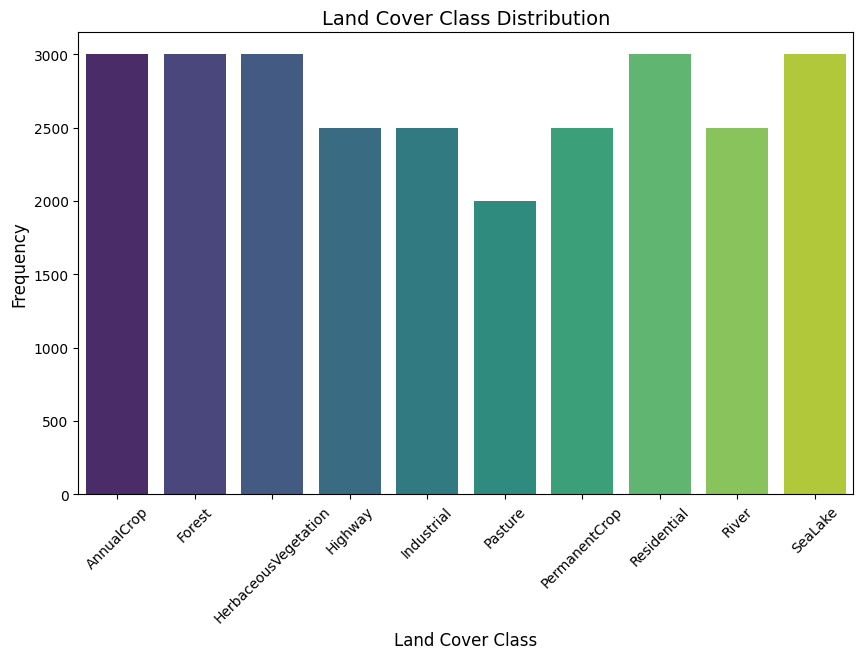

In [4]:
# Count occurrences of each class
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_classes, y=class_counts, hue=unique_classes, palette="viridis", legend=False)
plt.xlabel("Land Cover Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Land Cover Class Distribution", fontsize=14)
plt.xticks(rotation=45) 

print(unique_classes)

Comment on class balance: The data apprears to be fairly balanced. All classes have counts between 2000 and 3000. 

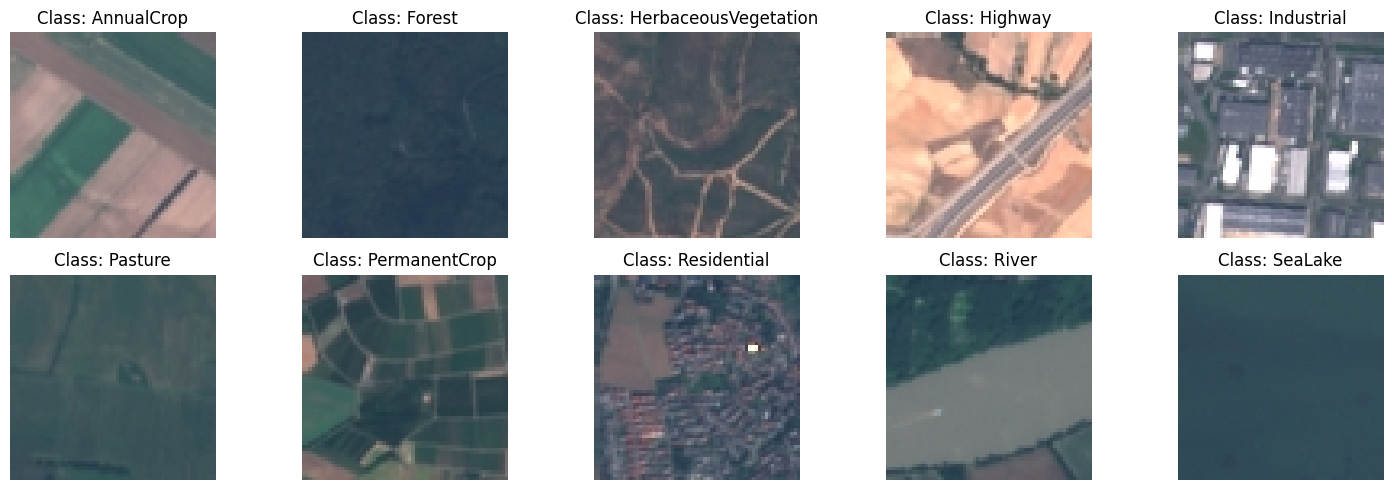

In [5]:
def display_1_image_per_class(X_train, Y_train, num_classes=10):
    plt.figure(figsize=(15, 5))

    unique_classes = np.unique(Y_train)  
    for i, class_id in enumerate(unique_classes):
        
        # Find the first data of the class
        class_indices = np.where(Y_train == class_id)[0]
        if len(class_indices) == 0:
            continue  
        class_idx = class_indices[0]

        plt.subplot(2, 5, i + 1)
        plt.imshow(X_train[class_idx], cmap='gray') 
        plt.title(f"Class: {class_id}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
display_1_image_per_class(images, labels, 10)


Most confused land classes: Forest and Pasture 

---
### Step 3: Data preprocessing

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.

    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    indices = np.arange(labels.shape[0])
    shuffled_indices = np.random.permutation(indices)
    images = images[shuffled_indices]
    labels = labels[shuffled_indices]

    # create data splits
    train_size, val_size, test_size = split
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=(val_size + test_size), random_state=1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), random_state=1234)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


In [9]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # conver images to a TF tensor
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)

    # image augmentation on training data
    if data_partition=="train":
        
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X_tf, delta=DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor


    # rescale image by dividing each pixel by 255.0
    X = X / 255.0

    return X, y

Comment on the importnace of adding augmented images to training data 
- Augmenting images in the training data improves model generalization by increasing the dataset size and variablity.
- Validation and test sets represent real data, so these data should not be augmented.

In [10]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [11]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

Accuracy on training data: 0.774
Accuracy on validation data: 0.406


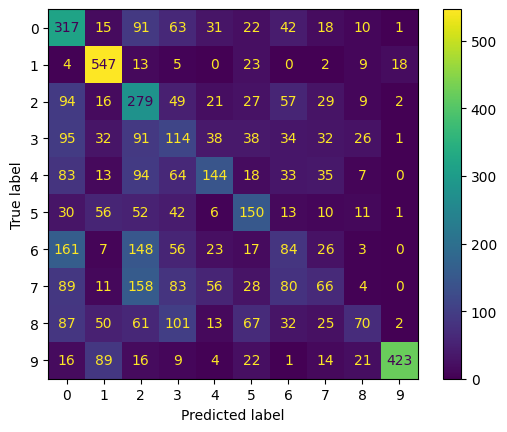

In [12]:
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=2, 
                                random_state=7,
                                n_jobs=1)
clf_forest = forest.fit(X_train_re, y_train)

print(f'Accuracy on training data: {clf_forest.score(X_train_re, y_train):.3f}')
print(f'Accuracy on validation data: {clf_forest.score(X_val_re, y_val):.3f}')


# plot confusion matrix using (y_val, y_val_pred) data.
y_val_pred = clf_forest.predict(X_val_re) 

conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()


Training accuracy (77.4%) is much higher than the validation accuracy (40.6%). 

The model does not generalize well. The model is overfitting as there is a large gap between the training accuracy vs. validation accuracy.

The model is confusing 'Permanent Crop' with 'Annual Crop' the most

Accuracy on training data: 0.984
Accuracy on validation data: 0.630


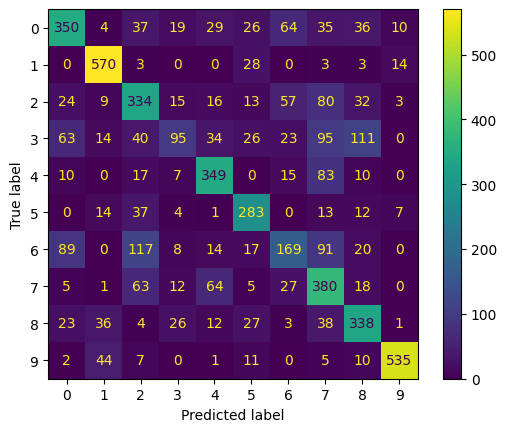

In [19]:
rf_clf2 = RandomForestClassifier(
    n_estimators=75,
    criterion='entropy',
    max_depth=15, 
    random_state=7,
    n_jobs=-1,
    min_samples_split=10,
    min_samples_leaf=5,
)

clf_forest2 = rf_clf2.fit(X_train_re, y_train)

print(f'Accuracy on training data: {clf_forest2.score(X_train_re, y_train):.3f}')
print(f'Accuracy on validation data: {clf_forest2.score(X_val_re, y_val):.3f}')


# plot confusion matrix using (y_val, y_val_pred) data.
y_val_pred = clf_forest2.predict(X_val_re) 

conf_matrix = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

Compared to the baseline classifier: 
- increasing n_estimators to 75 (number of trees)
- setting max_depth as 15 (limiting tree depth)
- reduced min leaf size to 5
- setting min_samples_split as 10 to avoid overfitting

Comment on training vs. validation performance relative to baseline model: 
- Training accuracy improved from 77% to 98%.
- Validation accuracy improved from 41% to 63%.
- However, the gap between training and validation accuracy remains the same, with a 30% difference.

Comment on the classes the model confuses the most relative to the baseline: The model is confusing 'Highway' with 'River' the most

---
### Step 5: Evaluation and Generalization

In [21]:
y_test_pred = clf_forest2.predict(X_test_re) 
print(f'Accuracy on test data: {clf_forest2.score(X_test_re, y_test):.3f}')

Accuracy on test data: 0.642


Comment on test set accuracy vs. training vs. validation set accuracy:
- Training accuracy is so much high, suggesting overfitting
- Test accuracy (64.2%) is very close to validation accuracy (63.0%), showing model's generalization
- Thus, the model generalizes well but it is still overfitted to the train data

---
### Step 6: Discussion

In [ ]:
I do not recommend a Decision Forest for land cover classification. 
The model struggles to distinguish similar satellite images, even though they belong to different classes.

Any propose to improve performance over the Decision Forest classifier?

- Neural networks or convolutional neural networks could improve performance over the Decision Forest classifier, 
as they can capture more complex patterns.